In [17]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import time
import datetime
import cv2
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image

from tensorflow.keras.utils import plot_model

from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, ReLU, Reshape, Conv2DTranspose
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Embedding, Concatenate, ZeroPadding2D
from tensorflow.keras.datasets import mnist

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/dira/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3397, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3284/1255170221.py", line 8, in <cell line: 8>
    import matplotlib.pyplot as plt
  File "/home/dira/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/matplotlib/__init__.py", line 113, in <module>
    from . import _api, _version, cbook, _docstring, rcsetup
  File "/home/dira/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/matplotlib/rcsetup.py", line 27, in <module>
    from matplotlib.colors import Colormap, is_color_like
  File "/home/dira/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/matplotlib/colors.py", line 52, in <module>
    from PIL.PngImagePlugin import PngInfo
  File "/home/dira/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/PIL/PngImagePlugin.py", line 42, in <module>
    from . import Image, ImageChops, ImageFile, ImagePalett

In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   try:
#     # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Memory growth must be set before GPUs have been initialized
#     print(e)

In [18]:
input_path_str = f'./heightmaps/octaves 7/train data/labels'
PATH_input = pathlib.Path(input_path_str)

test_path_str = f'./heightmaps/octaves 7/test data/labels'
PATH_TEST = pathlib.Path(test_path_str)
# real_path_str = f'/content/drive/MyDrive/AuE 8930 Deep Learning Project/Data/Final Project Folder Test Data/Original Test'
# PATH_real = pathlib.Path(real_path_str)

In [20]:
%ls

 Coppeliasim_Matlab_Communication/   README.md
 Data_pix2pix.ipynb                 'Screenshot from 2022-10-10 11-27-24.png'
 LICENSE                            'Screenshot from 2022-10-13 15-59-54.png'
 LIDAR_Data_Generator.ipynb          terrain_obstacles/
 obstacles_only/                     terrain_only/


In [4]:
def load(input_file, real_file):
    # Read and decode an image file to a uint8 tensor
    in_file = tf.io.read_file(input_file)
    input_image = tf.io.decode_png(in_file)

    re_file = tf.io.read_file(real_file)
    real_image = tf.io.decode_png(re_file)
    # Split each image tensor into two tensors:
    # - one with a real building facade image
    # - one with an architecture label image 
    # w = tf.shape(image)[1]
    # w = w // 2
    # input_image = image[:, w:, :]
    # real_image = image[:, :w, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [5]:
# iip = input (LIDAR reading) image
iip=str(PATH_input / 'L_O7_H1.png')
print(iip)
# rip - label (expected output) image
rip=(str(PATH_input / 'L_O7_H1.png')).replace('labels\\L_','inputs\\')
print(rip)

heightmaps\octaves 7\train data\labels\L_O7_H1.png
heightmaps\octaves 7\train data\inputs\O7_H1.png


(TensorShape([250, 250, 1]), TensorShape([250, 250, 1]))

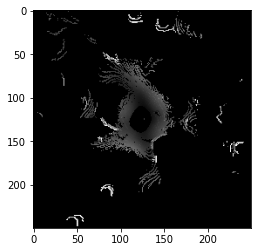

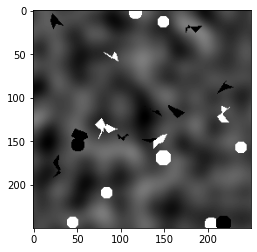

In [6]:
inp, re = load(iip, rip)
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(tf.squeeze(inp) / 255.0, cmap='gray')
plt.figure()
plt.imshow(tf.squeeze(re) / 255.0, cmap='gray')
inp.shape, re.shape

In [7]:
# The facade training set consist of 400 images
BUFFER_SIZE = 1000
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 250
IMG_HEIGHT = 250

In [8]:
def normalize01(input_image, real_image):
    input_image = (input_image / 255.0)
    real_image = (real_image / 255.0)

    return input_image, real_image

In [9]:
def load_image_train(data_file):
#     print(data_file)
    input_file = data_file
    temp_file = tf.strings.regex_replace(
            data_file, 'labels', 'inputs', 
            replace_global=True, name=None)
    real_file = tf.strings.regex_replace(
            temp_file, 'L_', '', 
            replace_global=True, name=None)
    # data_file.replace('Labels Test/Label_','Original Test/Original_')
    input_image, real_image = load(input_file, real_file)
    # input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize01(input_image, real_image)

    return input_image, real_image

In [10]:
train_dataset = tf.data.Dataset.list_files(str(PATH_input / 'L_*.png'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [11]:
tot_imgs=len(train_dataset)

In [12]:
i=0
for pt in train_dataset:
    i+=1
#     print(pt)
#     str_old = 'Labels O3 Training Data'+'\\'+'Label_'
#     str_new = 'Original O3 Training Data'+'\\'+'Original_'
#     b=tf.strings.regex_replace(
#             pt, str_old, str_new, name=None)
#     print(b)
print(i)

8919


In [13]:
try:
    test_dataset = tf.data.Dataset.list_files(str(PATH_TEST / 'L_*.png'))
except tf.errors.InvalidArgumentError:
    test_dataset = tf.data.Dataset.list_files(str(PATH_TEST / 'L_*.png'))
test_dataset = test_dataset.map(load_image_train)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [14]:
i=0
for ta in test_dataset:
    i+=1
#     print(ta)
#     str_old = 'Labels O3 Test Data'#+'\\'+'Label_'
#     str_new = 'Original O3 Test Data'#+'\\'+'Original_'
#     ba=tf.strings.regex_replace(
#             ta, str_old, str_new, name=None)
#     print(ba)
print(i)

1000


In [15]:
tot_imgs_test=len(test_dataset)

In [16]:
OUTPUT_CHANNELS = 1 ##change

In [17]:
def downsample(filters, size, strides=2, padding='same', apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(Conv2D(filters, size, strides, padding,
                kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())

    return result

In [18]:
def upsample(filters, size, strides=2, padding='same', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = Sequential()
    result.add(
    Conv2DTranspose(filters, size, strides,
                                    padding,
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(BatchNormalization())

    if apply_dropout:
        result.add(Dropout(0.5))

    result.add(ReLU())

    return result

In [19]:
# down_model = downsample(3, 3, padding='valid')
# down_result = down_model(tf.expand_dims(inp, 0))
# print (down_result.shape)

In [20]:
# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print (up_result.shape)

In [21]:
# input_shape = (4, 250, 250, 3)
# x = tf.random.normal(input_shape)
# y = tf.keras.layers.Conv2D(
# filters=32, kernel_size=10, strides=2,activation='relu', input_shape=input_shape[1:])(x)
# print(y.shape)


In [22]:
rows, cols=121, 121
strides = (2,2)
kernel_size = (10,10)
padding = (0,0)
output_padding = (0,0)

new_rows = ((rows - 1) * strides[0] + kernel_size[0] - 2 * padding[0] +
output_padding[0])
new_cols = ((cols - 1) * strides[1] + kernel_size[1] - 2 * padding[1] +
output_padding[1])
print(new_rows, new_cols)

250 250


In [23]:
def Generator():
    inputs = Input(shape=[250, 250, 1])

    down_stack = [
    downsample(32, 10, strides=2, padding='valid'), # (batch_size, 121, 121, 32)
    downsample(64, 3, padding='valid', apply_batchnorm=False),  # (batch_size, 60, 60, 64)
    downsample(128, 4),  # (batch_size, 30, 30, 128)
    downsample(256, 4, padding='valid'),  # (batch_size, 14, 14, 256)
    downsample(512, 4),  # (batch_size, 7, 7, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 512)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 512)
    upsample(512, 4, strides=1, padding='valid',apply_dropout=True),  # (batch_size, 7, 7, 512)
    upsample(512, 4),  # (batch_size, 14, 14, 512)
    upsample(256, 4, padding='valid'),  # (batch_size, 30, 30, 256)
    upsample(128, 4),  # (batch_size, 60, 60, 128)
    upsample(128, 3, padding='valid')
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(OUTPUT_CHANNELS, 10,
                                         strides=2,
                                         padding='valid',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 121, 121, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)

    return Model(inputs=inputs, outputs=x)

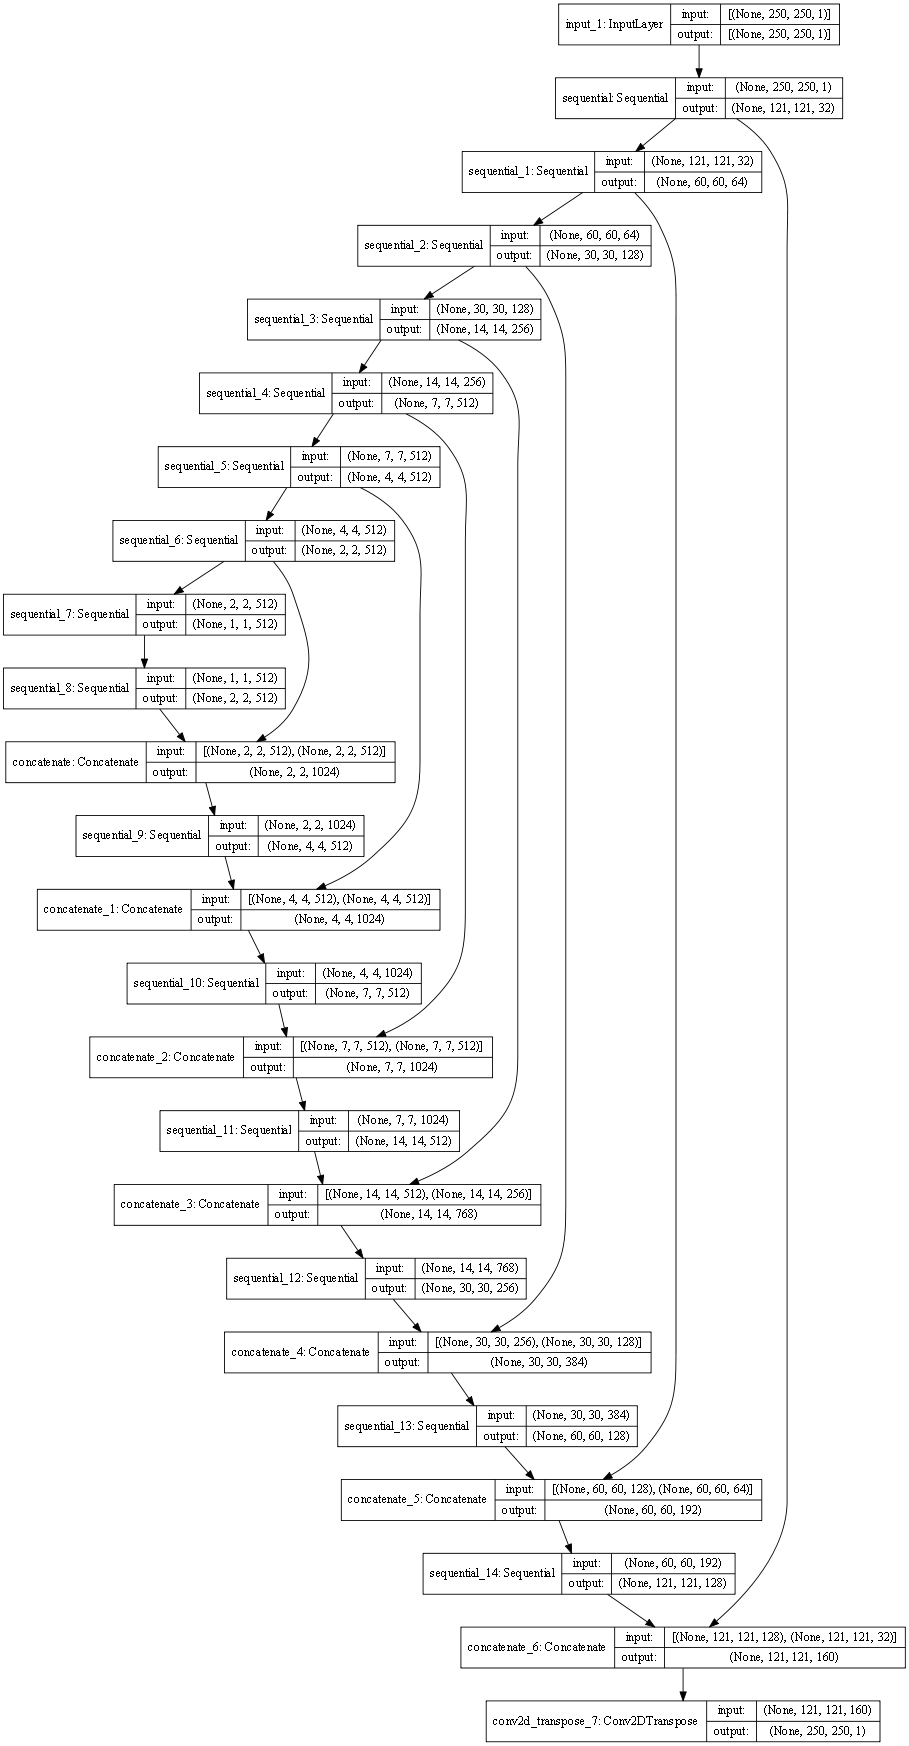

In [24]:
generator = Generator()
plot_model(generator, show_shapes=True, dpi=64)

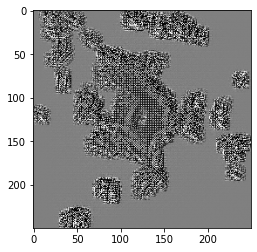

In [25]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(tf.squeeze(gen_output[0, ...]), cmap='gray')

In [26]:
LAMBDA = 100

In [27]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [29]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape=[250, 250, 1], name='input_image')
    tar = Input(shape=[250, 250, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 250, 250, channels*2)
    print(type(x))

    down1 = downsample(64, 4, apply_batchnorm=False)(x)  # (batch_size, 125, 125, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 63, 63, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
    down4 = downsample(256, 4)(down3)  # (batch_size, 16, 16, 256)

    zero_pad1 = ZeroPadding2D()(down4)  # (batch_size, 18, 18, 256)
    conv = Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 15, 15, 512)

    batchnorm1 = BatchNormalization()(conv)

    leaky_relu = LeakyReLU()(batchnorm1)

    zero_pad2 = ZeroPadding2D()(leaky_relu)  # (batch_size, 17, 17, 512)

    last = Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 14, 14, 1)

    return Model(inputs=[inp, tar], outputs=last)

<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>


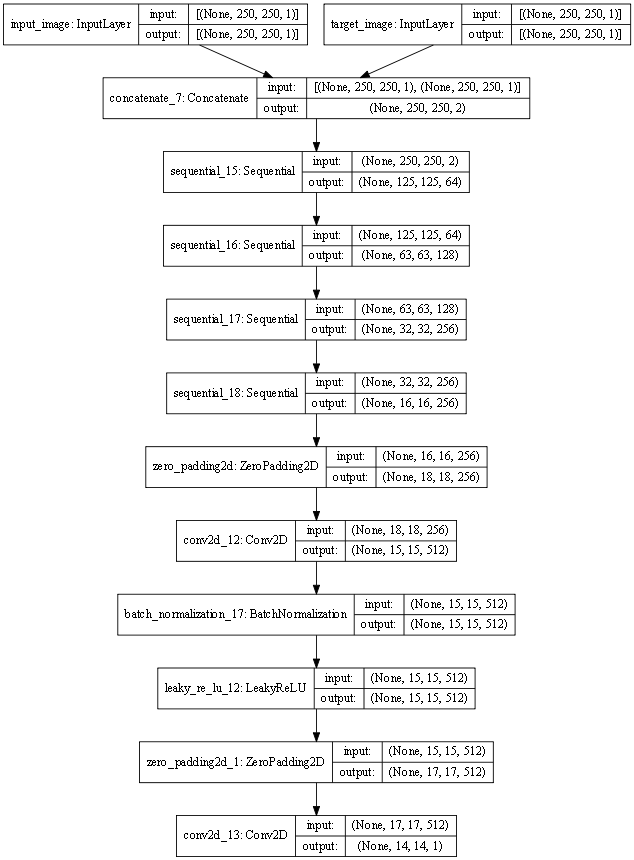

In [30]:
discriminator = Discriminator()
plot_model(discriminator, show_shapes=True, dpi=64)

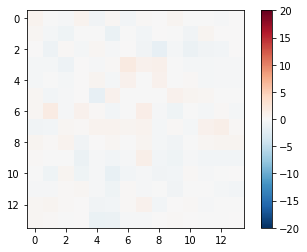

In [31]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [32]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(tf.squeeze(display_list[i]) * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [36]:
def generate_images_11(model, test_input, tar,step):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(5, 5))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        # Getting the pixel values in the [0, 1] range to plot.
        
        plt.imshow(tf.squeeze(display_list[i]) * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
        plt.savefig('./Results/'+title[i]+str(step)+'.png')  
#         pic_np = (tf.squeeze(display_list[i]) * 0.5 + 0.5).astype('uint8')
#         pil_img = Image.fromarray(pic_np, 'L')
#         img_path='./Results/'+title[i]+str(step)+'.png'
#         pil_img.save(img_path)
    plt.show()

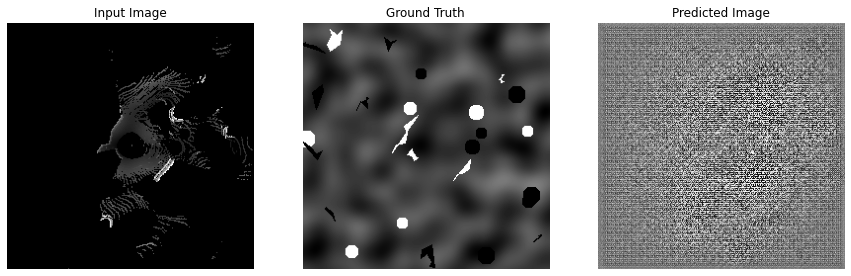

In [37]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [38]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [39]:
@tf.function
def train_step(input_image, target, step):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

#     epc=step//tot_imgs
#     bth=step%tot_imgs
#     # sess = tf.compat.v1.Session()
#     # print(gen_total_loss)
#     # # print(sess.run(gen_total_loss))
#     # print(gen_l1_loss)
#     # print(gen_gan_loss)
#     # print(disc_loss)
#     all_generator_total_losses[epc, bth] = gen_total_loss.numpy()
#     all_generator_l1_losses[epc, bth] = gen_l1_loss.numpy()
#     all_generator_gan_losses[epc, bth] = gen_gan_loss.numpy()
#     all_discriminator_losses[epc, bth] = disc_loss.numpy()

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [40]:
# @tf.function
# def train_step(input_image, target, step):
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         gen_output = generator(input_image, training=True)

#         disc_real_output = discriminator([input_image, target], training=True)
#         disc_generated_output = discriminator([input_image, gen_output], training=True)

#         gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
#         disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

#     generator_gradients = gen_tape.gradient(gen_total_loss,
#                                           generator.trainable_variables)
#     discriminator_gradients = disc_tape.gradient(disc_loss,
#                                                discriminator.trainable_variables)

#     generator_optimizer.apply_gradients(zip(generator_gradients,
#                                           generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
#                                               discriminator.trainable_variables))

#     with summary_writer.as_default():
#         tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
#         tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
#         tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
#         tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [41]:
def fit(train_ds, test_ds, epochs):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()
    leap = 0
    for step, (input_image, target) in train_ds.repeat(epochs).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 images: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        if step%batches == 0:
            generate_images_11(generator, example_input, example_target,leap)

            leap = leap + 1

In [42]:
# def fit(train_ds, test_ds, steps):
#     example_input, example_target = next(iter(test_ds.take(1)))
#     start = time.time()
#     leap = 0
#     for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        
#         if (step) % 1000 == 0:
#             display.clear_output(wait=True)

#             if step != 0:
#                 print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

#             start = time.time()

#             generate_images(generator, example_input, example_target)
#             print(f"Step: {step//1000}k")
            
#         train_step(input_image, target, step)

#         # Training step
#         if (step+1) % 10 == 0:
#             print('.', end='', flush=True)


#         # Save (checkpoint) the model every 5k steps
#         if (step + 1) % 5000 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)
        
#         if leap%1000 == 0:
#                 generate_images_11(generator, example_input, example_target, leap)
        
#         leap = leap + 1

In [43]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

In [44]:
# with tf.device('/device:GPU:0'):
#     fit(train_dataset, test_dataset, steps=20000)

In [45]:
epochs=2
batches=tot_imgs
all_generator_total_losses = np.zeros([epochs, batches])
all_generator_l1_losses = np.zeros([epochs, batches])
all_generator_gan_losses = np.zeros([epochs, batches])
all_discriminator_losses = np.zeros([epochs, batches])

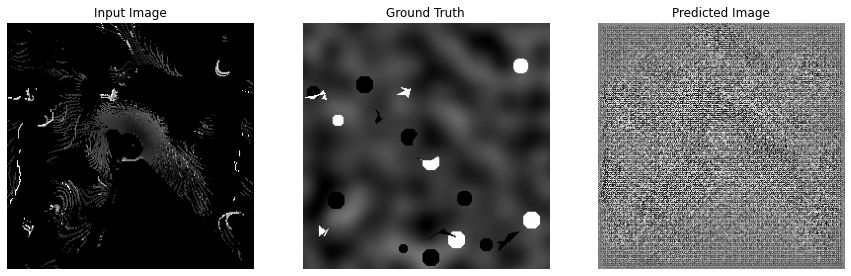

Step: 0k


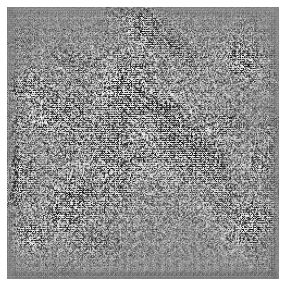

....................................

KeyboardInterrupt: 

In [46]:
with tf.device('/device:GPU:0'):
    fit(train_dataset, test_dataset, epochs)